In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.models import load_model

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight

from collections import defaultdict
import cv2

import os
import warnings
warnings.filterwarnings('ignore')

In [4]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 0


In [5]:
base_dir = 'Dataset'

classes = os.listdir(base_dir)
print("Classes Found:", classes)

Classes Found: ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']


In [6]:
for cls in classes:
    cls_dir = os.path.join(base_dir,cls)
    num_images = len(os.listdir(cls_dir))
    print(f"Number of images in class {cls}: {num_images}")



Number of images in class Blight: 1146
Number of images in class Common_Rust: 1306
Number of images in class Gray_Leaf_Spot: 574
Number of images in class Healthy: 1162


In [7]:
image_shape = {}

for cls in classes:
    cls_dir = os.path.join(base_dir,cls)
    images = os.listdir(cls_dir)[:5]
    shapes = []
    for img_name in images:
        img_path = os.path.join(cls_dir,img_name)
        img = cv2.imread(img_path)
        if img is not None:
            shapes.append(img.shape[:2])
            image_shape[cls] = shapes

for cls, dims in image_shape.items():
    print(f"Sample image dimensions for class '{cls}': {dims}")

Sample image dimensions for class 'Blight': [(585, 1000), (371, 788), (482, 641), (200, 300), (256, 256)]
Sample image dimensions for class 'Common_Rust': [(500, 185), (480, 640), (256, 256), (256, 256), (256, 256)]
Sample image dimensions for class 'Gray_Leaf_Spot': [(395, 525), (1591, 743), (256, 256), (256, 256), (256, 256)]
Sample image dimensions for class 'Healthy': [(256, 256), (256, 256), (256, 256), (256, 256), (256, 256)]


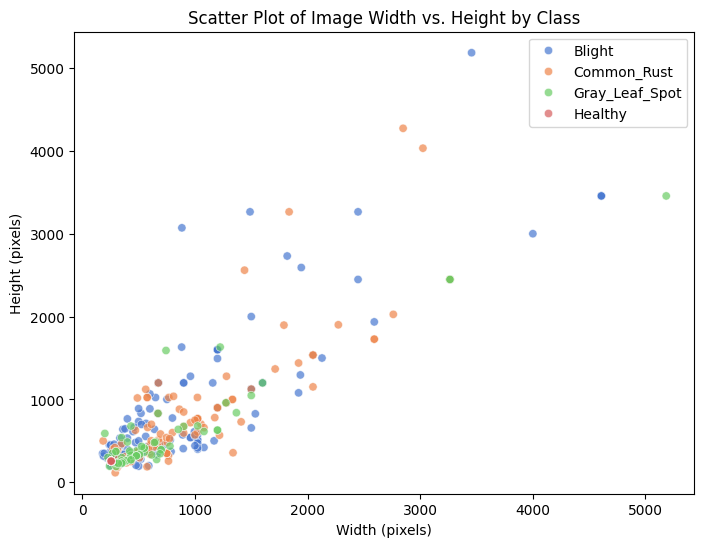

In [8]:
def img_stats(base_dir, classes):
    img_size = defaultdict(list)
    for cls in classes:
        cls_dir = os.path.join(base_dir,cls)
        for img_name in os.listdir(cls_dir):
            img_path = os.path.join(cls_dir, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                height, width = img.shape[:2]
                img_size['Class'].append(cls)
                img_size['Height'].append(height)
                img_size['Width'].append(width)
    return pd.DataFrame(img_size)

# Function to plot a scatter plot of Height vs. Width
def plot_scatter(df):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x='Width', y='Height', hue='Class', alpha=0.7, palette='muted')
    plt.title('Scatter Plot of Image Width vs. Height by Class')
    plt.xlabel('Width (pixels)')
    plt.ylabel('Height (pixels)')
    plt.legend(loc='upper right')
    plt.show()

df_img_sizes = img_stats(base_dir, classes)
plot_scatter(df_img_sizes)

In [9]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 40

In [10]:
dataset = tf.keras.preprocessing.image_dataset_from_directory('Dataset',
                                                              seed = 123,
                                                              shuffle = True,
                                                              image_size = (IMAGE_SIZE,IMAGE_SIZE),
                                                              batch_size = BATCH_SIZE
                                                              )

Found 4188 files belonging to 4 classes.


In [11]:
len(dataset) # gets the total number of batches in the dataset

131

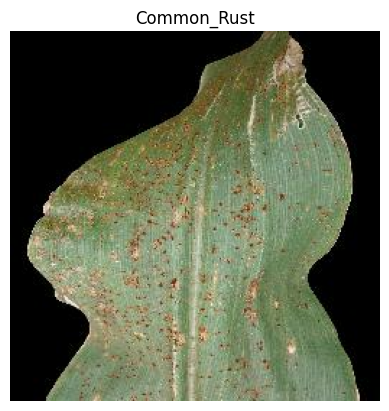

In [12]:
class_names = dataset.class_names        # Displaying a single image from a batch

for image_batch, labels_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[labels_batch[0]])
    plt.axis("off")
    plt.show()

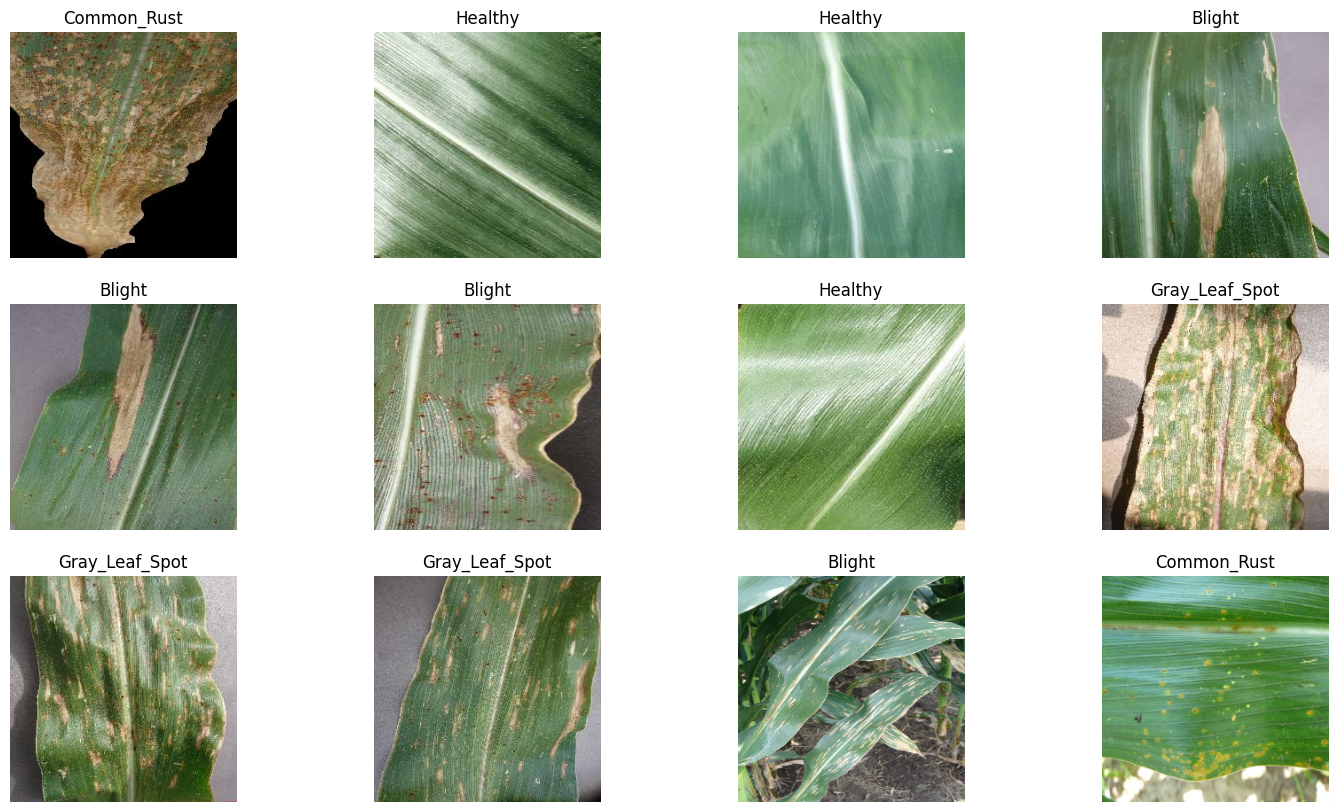

In [13]:
plt.figure(figsize=(18,10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")
plt.show()


In [14]:
def dataset_partitions(ds, train_split = 0.8, test_split = 0.1, val_split = 0.1,shuffle = True, shuffle_size = 10000):
    assert (train_split+test_split+val_split) == 1

    ds_size = ds.cardinality().numpy()
    print(f"Total dataset size: {ds_size}")

    if shuffle:
        shuffle_size = max(shuffle_size, ds_size)
        ds = ds.shuffle(shuffle_size,seed=123)

    # Calculate partition sizes
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    test_size = ds_size-train_size-val_size

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size+val_size)

    return train_ds, test_ds, val_ds

# Split the dataset
train_ds, val_ds, test_ds = dataset_partitions(dataset)

# Output the number of batches
print(f"Training batches: {len(train_ds)}")   
print(f"Validation batches: {len(val_ds)}")  
print(f"Testing batches: {len(test_ds)}")    

Total dataset size: 131
Training batches: 104
Validation batches: 14
Testing batches: 13


In [15]:
resize = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0/255)
])

train_ds = train_ds.map(lambda x, y: (resize(x), y))
val_ds = val_ds.map(lambda x, y: (resize(x), y))
test_ds = test_ds.map(lambda x, y: (resize(x), y))

In [16]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

train_ds = train_ds.map(lambda x,y: (data_augmentation(x),y))

In [17]:
n_classes = 4

#model
model = models.Sequential([
    layers.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS)),

    #First con layer
    layers.Conv2D(32,(3,3),activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    #Second con layer
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    #Third Con layer
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    #Fourth Con layer
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    #global average pooling
    layers.GlobalAveragePooling2D(),
    # layers.Flatten(),

    #Dense layer
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

In [18]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 250,756 (979.52 KB)

 Trainable params: 250,052 (976.77 KB)

 Non-trainable params: 704 (2.75 KB)

In [19]:
# tf.keras.utils.plot_model(model, show_shapes=True)

In [20]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [21]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1
)

# Add ModelCheckpoint to callbacks
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    save_best_only=True
)

callbacks = [early_stopping, reduce_lr, model_checkpoint]

In [22]:
# Extract labels for batched dataset
y_train = []
for _, y in train_ds.unbatch():
    y_train.append(y.numpy().item())  # Use item() to extract scalar value
y_train = np.array(y_train)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

In [23]:
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = EPOCHS,
    verbose = 1,
    class_weight = class_weights,
    callbacks = callbacks
)

Epoch 1/40
104/104 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.7365 - loss: 0.6807 - val_accuracy: 0.4754 - val_loss: 1.7119 - learning_rate: 0.0010
Epoch 2/40
104/104 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.8315 - loss: 0.4562 - val_accuracy: 0.3304 - val_loss: 1.4640 - learning_rate: 0.0010
Epoch 3/40
104/104 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.8605 - loss: 0.3917 - val_accuracy: 0.5335 - val_loss: 1.2717 - learning_rate: 0.0010
Epoch 4/40
104/104 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.8847 - loss: 0.3280 - val_accuracy: 0.7768 - val_loss: 0.7374 - learning_rate: 0.0010
Epoch 5/40
104/104 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.8864 - loss: 0.3241 - val_accuracy: 0.7835 - val_loss: 0.6064 - learning_rate: 0.0010
Epoch 6/40
104/104 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.8875 - loss: 0.3048 - val_accuracy: 0.7969 - val_loss: 0.5268 - learning_rate: 0.0010
Epoch 7/40
104/104 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.8814 - loss: 0.

In [24]:
scores = model.evaluate(test_ds)
print(f"Test loss: {scores[0]} and Test accuracy: {scores[1]}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - accuracy: 0.9351 - loss: 0.1557
Test loss: 0.14834904670715332 and Test accuracy: 0.946601927280426


In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

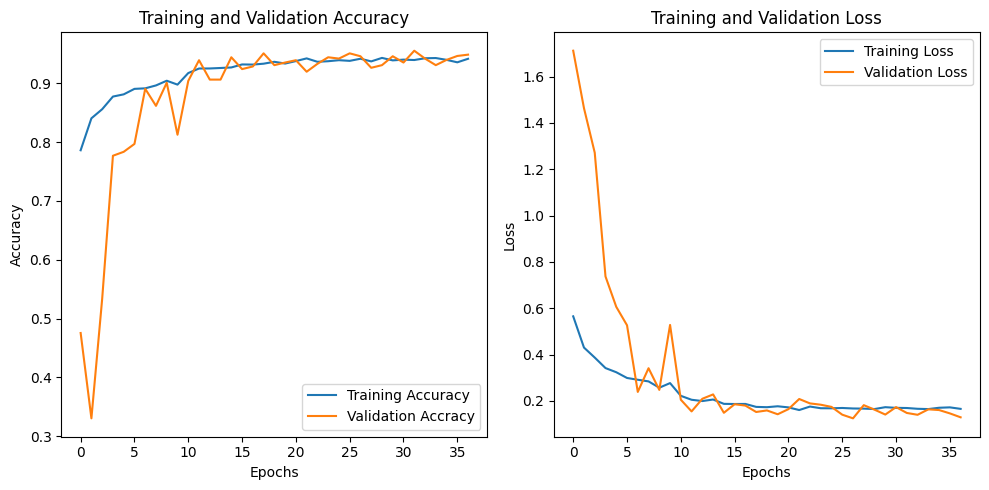

In [29]:
plt.figure(figsize=(10,5))

# Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label = 'Validation Accracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()
